In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install yfinance
import yfinance as yf
import datetime

# Today ka date
end = datetime.datetime.today().strftime('%Y-%m-%d')

# Apple stock data (2015 se aaj tak)
df = yf.download("AAPL", start="2015-01-01", end=end)

# Output check
print("Data shape:", df.shape)
print(df.head())
print(df.tail())   # last rows dikhne ke liye (latest data confirm hoga)

/tmp/ipython-input-2432842633.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-01-01", end=end)
[*********************100%***********************]  1 of 1 completed

Data shape: (2684, 5)
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261047  24.729270  23.821672  24.718174  212818400
2015-01-05  23.577578  24.110154  23.391177  24.030267  257142000
2015-01-06  23.579792  23.839422  23.218083  23.641926  263188400
2015-01-07  23.910439  24.010296  23.677436  23.788389  160423600
2015-01-08  24.829130  24.886826  24.121248  24.238859  237458000
Price            Close        High         Low        Open    Volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-08-28  232.559998  233.410004  229.339996  230.820007  38074700
2025-08-29  232.139999  233.380005  231.369995  232.509995  39418400
2025-09-02  229.720001  230.850006  226.970001  229.250000  44075600
2025-09-03  238.470001  238.850006  

In [ ]:
# Flatten multi-index columns
df.columns = df.columns.droplevel(0)   # Remove "Price"
df.columns = ["Close", "High", "Low", "Open", "Volume"]

print(df.head())
print(df.tail())

                Close       High        Low       Open     Volume
Date                                                             
2015-01-02  24.261047  24.729270  23.821672  24.718174  212818400
2015-01-05  23.577578  24.110154  23.391177  24.030267  257142000
2015-01-06  23.579792  23.839422  23.218083  23.641926  263188400
2015-01-07  23.910439  24.010296  23.677436  23.788389  160423600
2015-01-08  24.829130  24.886826  24.121248  24.238859  237458000
                 Close        High         Low        Open    Volume
Date                                                                
2025-08-28  232.559998  233.410004  229.339996  230.820007  38074700
2025-08-29  232.139999  233.380005  231.369995  232.509995  39418400
2025-09-02  229.720001  230.850006  226.970001  229.250000  44075600
2025-09-03  238.470001  238.850006  234.360001  237.210007  66427800
2025-09-04  239.779999  239.899994  236.740005  238.449997  47504000


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Copy the original dataframe
df_processed = df.copy()

# Only compute MA if 'Close' exists
if 'Close' in df_processed.columns:
    df_processed['MA5'] = df_processed['Close'].rolling(window=5).mean()
    df_processed['MA10'] = df_processed['Close'].rolling(window=10).mean()
    df_processed['MA20'] = df_processed['Close'].rolling(window=20).mean()
    df_processed['MA50'] = df_processed['Close'].rolling(window=50).mean()

# Drop rows with NaN values (from rolling calculations)
df_processed = df_processed.dropna()

# Columns that actually exist for scaling
columns_to_scale = [col for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'MA5', 'MA10', 'MA20', 'MA50']
                    if col in df_processed.columns]

# Normalize
scaler = MinMaxScaler()
df_processed[columns_to_scale] = scaler.fit_transform(df_processed[columns_to_scale])

# Print shape and first 5 rows
print("Processed Data Shape:", df_processed.shape)
display(df_processed.head())




Processed Data Shape: (2635, 9)


,Close,High,Low,Open,Volume,MA5,MA10,MA20,MA50
Date,,,,,,,,,
2015-03-16,0.030371,0.028999,0.029403,0.029789,0.192238,0.028256,0.029652,0.030853,0.021855
2015-03-17,0.032332,0.031215,0.032024,0.031690,0.289099,0.028737,0.029429,0.030814,0.022226
2015-03-18,0.033674,0.032935,0.032703,0.032725,0.380199,0.029920,0.029422,0.030802,0.022688
2015-03-19,0.032764,0.033019,0.033674,0.034372,0.255764,0.030499,0.029527,0.030756,0.023131
2015-03-20,0.031263,0.032225,0.031563,0.033901,0.402093,0.030938,0.029460,0.030580,0.023510


In [ ]:
import numpy as np

def create_lstm_dataset(df, window_size=60, target_col='Close'):

    dataset = df.values  # convert DataFrame to NumPy array
    feature_names = df.columns.tolist()

    # Find target column index
    target_idx = feature_names.index(target_col)

    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i - window_size:i])
        y.append(dataset[i, target_idx])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    print(f"Created {X.shape[0]} samples with window size {window_size}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    return X, y

# Example usage
window_size = 60
X, y = create_lstm_dataset(df_processed, window_size=window_size, target_col='Close')


Created 2575 samples with window size 60
X shape: (2575, 60, 9), y shape: (2575,)


In [ ]:
# split the dataset into train and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# print the shapes of the train and test sets
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (2060, 60, 9)
y_train shape: (2060,)
X_test shape: (515, 60, 9)
y_test shape: (515,)


Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0115 - val_loss: 0.0022
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.1563e-04 - val_loss: 0.0013
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.4772e-04 - val_loss: 7.5136e-04
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.8078e-04 - val_loss: 0.0039
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.0753e-04 - val_loss: 0.0035
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.5264e-04 - val_loss: 9.1918e-04
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 7.8132e-04 - val_loss: 7.2457e-04
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.7887e-04 - val_loss: 7.7393e-04
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.0493e-04 - val_loss: 5.8115e-04
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.4949e-04 - val_loss: 6.7

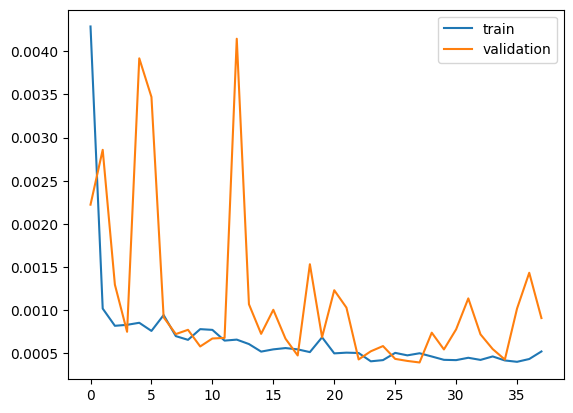

In [ ]:
# 6. Create Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout

# 3 layers of LSTM with 50 units
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# add early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1, callbacks=[early_stopping])

# plot the training loss and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 563ms/step - loss: 0.0274 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 547ms/step - loss: 0.0025 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 523ms/step - loss: 0.0023 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 567ms/step - loss: 0.0019 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 531ms/step - loss: 0.0020 - val_loss: 9.9340e-04 - learning_rate: 0.0010
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 529ms/step - loss: 0.0017 - val_loss: 8.7551e-04 - learning_rate: 0.0010
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 572ms/step - loss: 0.0018 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 526ms/step - loss: 0.0016 - val_loss: 8.6048e-04 - learning_rate: 0.0010
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 533ms/step - loss: 0.0018 - val_loss: 0.0013 - le

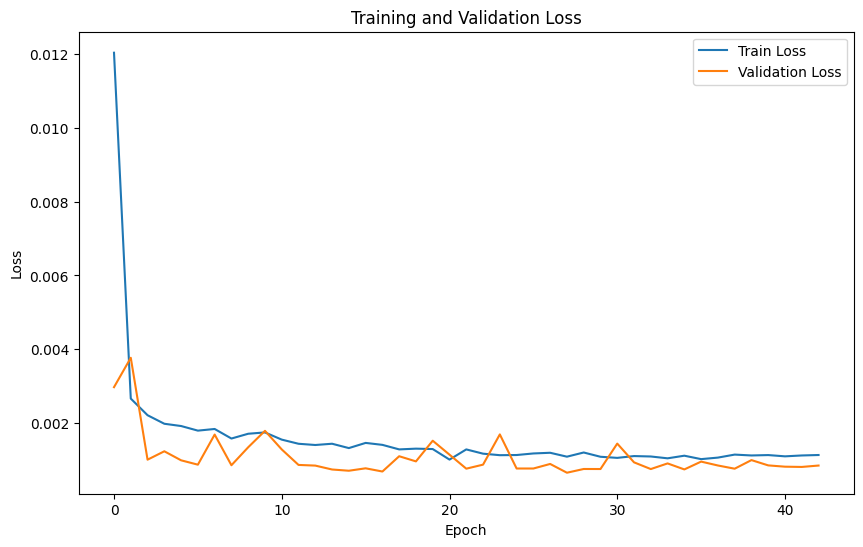

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define the model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=True, recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(LSTM(50, recurrent_dropout=0.2))  # reduced last layer units
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

# Plot losses
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


65/65 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step
Mean Squared Error on Training Data: 20.250688552856445
Root Mean Squared Error on Training Data: 4.5000765052226
Mean Absolute Percentage Error on Training Data: 3.8235269


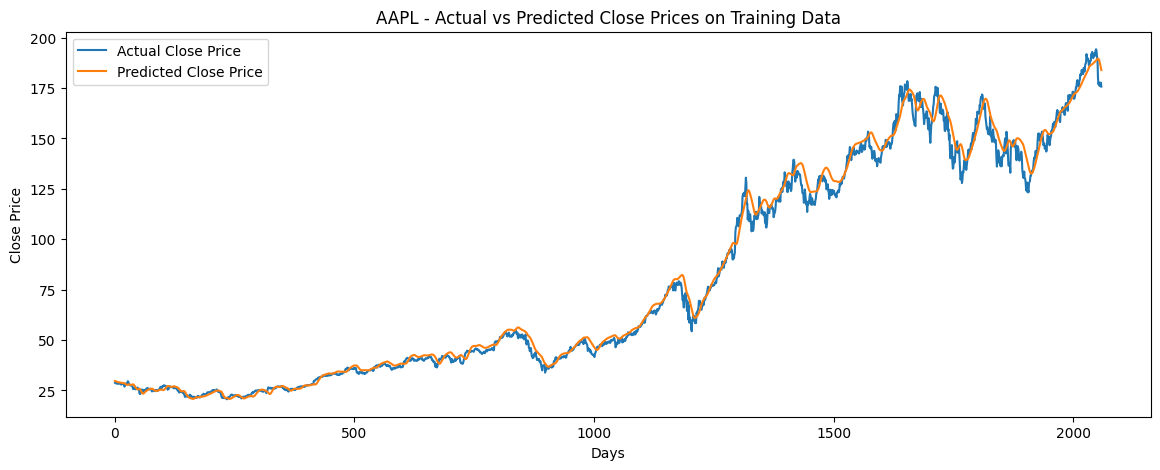

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Fit a separate scaler for the 'Close' prices
close_scaler = MinMaxScaler()
close_scaler.fit(df[['Close']])  # Fit the scaler on the original 'Close' prices

# Predict on training data
y_pred = model.predict(X_train)

# Inverse the normalization for predicted and actual values
y_pred_inv = close_scaler.inverse_transform(y_pred)
y_train_inv = close_scaler.inverse_transform(y_train.reshape(-1, 1))

# calculate mean squared error on training data
mse_train = mean_squared_error(y_train_inv, y_pred_inv)
print('Mean Squared Error on Training Data:', mse_train)

# calculate root mean squared error on training data
rmse_train = np.sqrt(mse_train)
print('Root Mean Squared Error on Training Data:', rmse_train)

# calculate mape on training data
mape_train = np.mean(np.abs((y_train_inv - y_pred_inv) / y_train_inv)) * 100
print('Mean Absolute Percentage Error on Training Data:', mape_train)

# Plot the actual and predicted values
plt.figure(figsize=(14, 5))
plt.plot(y_train_inv, label='Actual Close Price')
plt.plot(y_pred_inv, label='Predicted Close Price')
plt.title('AAPL - Actual vs Predicted Close Prices on Training Data')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step


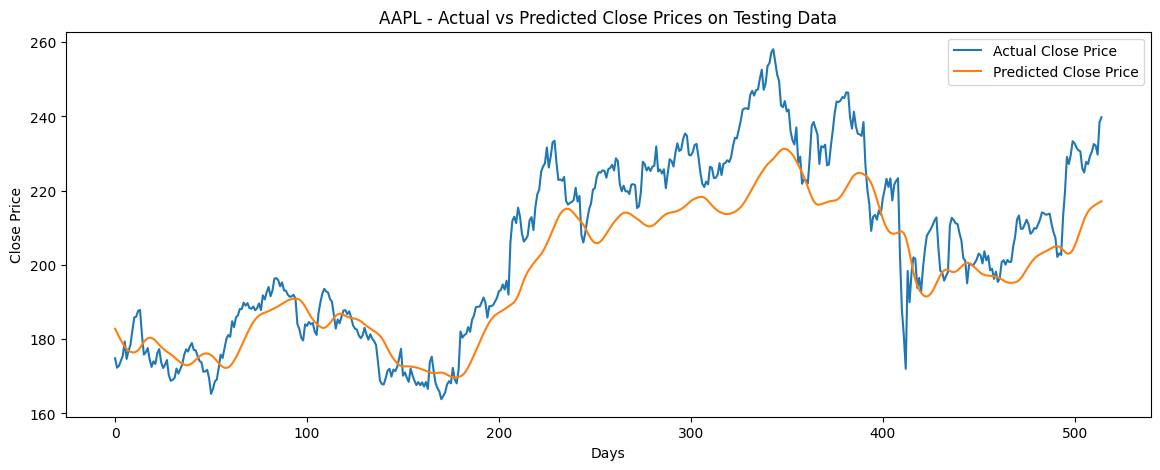

Mean Squared Error on Testing Data: 143.4697265625
Root Mean Squared Error on Testing Data: 11.977884895193307
Mean Absolute Percentage Error on Testing Data: 4.4322404861450195%


In [ ]:
from sklearn.metrics import mean_squared_error

# Select the last 250 rows from the test data
# X_test_last_250 = X_test[-250:]
# y_test_last_250 = y_test[-250:]
X_test_last_250 = X_test
y_test_last_250 = y_test

# Predict on the last 250 rows of testing data
y_pred_test = model.predict(X_test_last_250)

# Inverse the normalization for predicted and actual values
y_pred_test_inv = close_scaler.inverse_transform(y_pred_test)
y_test_last_250_inv = close_scaler.inverse_transform(y_test_last_250.reshape(-1, 1))

# Plot the actual and predicted values on testing data
plt.figure(figsize=(14, 5))
plt.plot(y_test_last_250_inv, label='Actual Close Price')
plt.plot(y_pred_test_inv, label='Predicted Close Price')
plt.title('AAPL - Actual vs Predicted Close Prices on Testing Data')
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate the Mean Squared Error on testing data
mse = mean_squared_error(y_test_last_250_inv, y_pred_test_inv)
print(f'Mean Squared Error on Testing Data: {mse}')

# Calculate the Root Mean Squared Error (RMSE) on testing data
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error on Testing Data: {rmse}')

# Calculate the Mean Absolute Percentage Error (MAPE) on testing data
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test_last_250_inv, y_pred_test_inv)
print(f'Mean Absolute Percentage Error on Testing Data: {mape}%')

In [ ]:
import pandas as pd

# --- Last 60 days ka data (scaled) ---
# Use the last 'window_size' rows from the processed data
last_60_days = df_processed.iloc[-window_size:].values

# Number of features (columns) in the processed data
num_features = df_processed.shape[1]


# --- Dates for prediction ---
# Using the last date from the processed data as the start date for future predictions
last_date = df_processed.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7) # Predicting next 7 days


# --- Predictions ---
predictions_scaled = []
# Start with the last 60 days sequence from the processed data for the first prediction input
current_sequence = last_60_days.reshape((1, window_size, num_features))

for _ in range(len(future_dates)):
    # Predict the next step (scaled value)
    pred_scaled = model.predict(current_sequence)
    predictions_scaled.append(pred_scaled[0][0]) # Store the predicted 'Close' price

    # Prepare input for next prediction (sliding window)
    # Take the last time step from the current sequence, remove the first element along axis 1,
    # and append the new prediction at the end. We need to reconstruct the full feature set for the next time step.

    # Get the features of the very last time step from the current sequence
    last_timestep_features = current_sequence[:, -1, :].copy()

    # Update the 'Close' price feature with the new prediction
    # We need to find the index of the 'Close' column in the original df_processed
    close_col_index = df_processed.columns.get_loc('Close')
    last_timestep_features[0, close_col_index] = pred_scaled[0][0]


    # Remove the first time step from the current sequence
    updated_sequence = current_sequence[:, 1:, :]

    # Append the updated last timestep features to the sequence
    current_sequence = np.append(updated_sequence, last_timestep_features.reshape(1, 1, -1), axis=1)


# --- Inverse scale ---
# Inverse transform the scaled future predictions using the close_scaler
pred_prices = close_scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1)).flatten()

# --- DataFrame ---
pred_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': pred_prices})

# Display the predictions
print("Future Price Predictions:")
display(pred_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Future Price Predictions:


,Date,Predicted_Close
0,2025-09-05,217.524200
1,2025-09-06,217.917221
2,2025-09-07,218.259277
3,2025-09-08,218.533051
4,2025-09-09,218.738907
5,2025-09-10,218.885406
6,2025-09-11,218.983856


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Predicted_Close'].plot(kind='hist', bins=20, title='Predicted_Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='Predicted_Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date'}, axis=1)
              .sort_values('Date', ascending=True))
  xs = counted['Date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Predicted_Close']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Predicted_Close'}, axis=1)
              .sort_values('Predicted_Close', ascending=True))
  xs = counted['Predicted_Close']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Predicted_Close', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Predicted_Close')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['Predicted_Close'].plot(kind='line', figsize=(8, 4), title='Predicted_Close')
plt.gca().spines[['top', 'right']].set_visible(False)

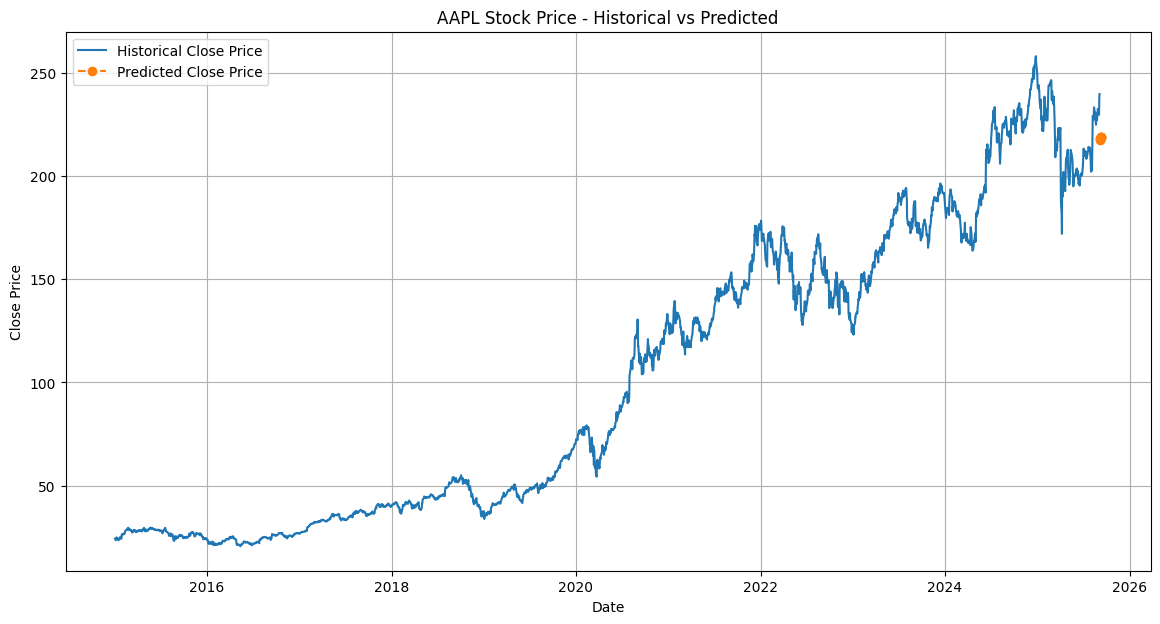

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(14, 7))

# Plot historical data (using the original df for actual prices before scaling)
# Since the date index is preserved in df_processed, we can use its index for plotting historical data from df
plt.plot(df.index, df['Close'], label='Historical Close Price')

# Plot predicted data
plt.plot(pred_df['Date'], pred_df['Predicted_Close'], label='Predicted Close Price', marker='o', linestyle='--')

plt.title('AAPL Stock Price - Historical vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()